In [1]:
# @TODO: try this for y-values
# sometimes this is called “non-parametric” in classical statistics
# rank-based /percentile cutoff

In [182]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
# import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR, ARResults
from scipy.misc import factorial as fact

%matplotlib inline

In [183]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

##Want something like:

In [184]:
def makeSQLQuery(table_names, year, seriesnames):
    dotyyear = '.y' + str(year)
    short = table_names[0][0:2]
    seriesnames = seriesnames
    abb = [ser[0:2] for ser in seriesnames]
    query = 'SELECT x.*, y' + dotyyear + ' as zscores FROM (' + \
            'SELECT ' + short + '.countrycode AS countrycode, ' + \
            short + dotyyear + ' AS ' + table_names[0] 
    
    mystr = ''
    for s in seriesnames:
        mystr = mystr + ', env.' + s
    mystr = mystr
    
    query = query + mystr
    
    query = query + ' FROM (SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[0] + ') ' + short + ' JOIN ' + \
        '(SELECT ' + abb[0] + '.countrycode AS countrycode'
    
    mystr = ''
    for a, ser in zip(abb, seriesnames):
        mystr = mystr + ', ' + a + dotyyear + ' as ' + ser
    query = query + mystr
    
    query = query + ' FROM ('
    
    subquery = []
    for a, ser in zip(abb, seriesnames):
        mystr = ''
        mystr = mystr + '(SELECT countrycode, ' + dotyyear[1:] + \
        ' FROM ' + table_names[1] + " WHERE series='" + ser + \
        "') " + a
        subquery.append(mystr)
    
    query = query + subquery[0] + ' JOIN ' + subquery[1] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[1] + '.countrycode' + \
        ' JOIN ' + subquery[2] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[2] + '.countrycode' + \
        ' JOIN ' + subquery[3] + ' ON ' + \
        abb[0] + '.countrycode = ' + abb[3] + '.countrycode)) env' + \
        ' ON ' + short + '.countrycode = env.countrycode'
        
    query = query + ') x JOIN (select countrycode, ' + dotyyear[1:] + \
            ' FROM zscores) y on x.countrycode = y.countrycode'
    
    return query

In [185]:
years = [x for x in range(2006, 2014)]

In [186]:
tables = ['forestarea', 'environment']
features = ['precipitation', 'extreme', 'arable_land', 'freshwater']
print makeSQLQuery(tables, years[0], features)

SELECT x.*, y.y2006 as zscores FROM (SELECT fo.countrycode AS countrycode, fo.y2006 AS forestarea, env.precipitation, env.extreme, env.arable_land, env.freshwater FROM (SELECT countrycode, y2006 FROM forestarea) fo JOIN (SELECT pr.countrycode AS countrycode, pr.y2006 as precipitation, ex.y2006 as extreme, ar.y2006 as arable_land, fr.y2006 as freshwater FROM ((SELECT countrycode, y2006 FROM environment WHERE series='precipitation') pr JOIN (SELECT countrycode, y2006 FROM environment WHERE series='extreme') ex ON pr.countrycode = ex.countrycode JOIN (SELECT countrycode, y2006 FROM environment WHERE series='arable_land') ar ON pr.countrycode = ar.countrycode JOIN (SELECT countrycode, y2006 FROM environment WHERE series='freshwater') fr ON pr.countrycode = fr.countrycode)) env ON fo.countrycode = env.countrycode) x JOIN (select countrycode, y2006 FROM zscores) y on x.countrycode = y.countrycode


In [187]:
df = pd.DataFrame()

In [188]:
for year in years:
    query = makeSQLQuery(tables, year, features)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    df = pd.concat([df, year_data])

In [21]:
df.columns

Index([u'forestarea', u'precipitation', u'extreme', u'arable_land',
       u'freshwater', u'zscores'],
      dtype='object')

In [16]:
df.size

7506

In [24]:
df.head()

,,forestarea,precipitation,extreme,arable_land,freshwater,zscores
countrycode,year,,,,,,
ARG,2006,10.913914,591,0.167190,12.735823,7305.496838,-0.278010269
AUS,2006,16.499616,534,3.047099,6.211031,23622.500912,-0.279337781
BRA,2006,60.429569,1761,0.482451,8.319794,29364.390723,-0.27919335
CHN,2006,20.723562,645,7.950971,11.578350,2134.480626,-0.272709544
FRA,2006,29.172541,867,0.005718,33.490456,3124.207769,-0.279344809


In [236]:
df['zscores'] = df['zscores'].astype(float)

In [29]:
df = df.dropna()

In [30]:
df.describe()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores
count,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000,2502.000000
mean,30.606953,1112.219025,1.214430,16.109750,14878.542330,0.040514
std,22.133838,757.134960,1.976777,13.874216,35020.530613,1.143605
min,0.067909,51.000000,0.000000,0.051769,0.000000,-0.293136
25%,11.078235,562.000000,0.023082,5.127726,1147.784317,-0.276353
50%,30.513576,1010.000000,0.269239,11.936709,3063.458600,-0.262625
75%,46.556322,1604.000000,1.295973,22.676412,12391.666391,-0.197219
max,98.506410,3240.000000,9.226586,60.536222,323213.140961,9.868634


In [237]:
df['binary'] = df['zscores'].apply(lambda x: 0 if x<0 else 1)

In [238]:
len(df[df['binary']==1])

210

In [239]:
len(df)

1264

In [240]:
210./1264*100

16.61392405063291

In [241]:
df.describe()

,forestarea,precipitation,extreme,arable_land,freshwater,zscores,binary
count,1.264000e+03,1.264000e+03,1.264000e+03,1.264000e+03,1.264000e+03,1251.000000,1264.000000
mean,2.152287e-15,-7.057470e-17,3.933211e-16,-1.772931e-15,-2.702216e-16,0.040514,0.166139
std,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.000396e+00,1.143833,0.372353
min,-1.389458e+00,-1.409071e+00,-6.101924e-01,-1.159221e+00,-4.230200e-01,-0.293136,0.000000
25%,-8.895367e-01,-7.309438e-01,-5.989275e-01,-7.881658e-01,-3.896084e-01,-0.276345,0.000000
50%,2.097412e-03,-1.420001e-01,-4.746600e-01,-2.999419e-01,-3.371951e-01,-0.262625,0.000000
75%,7.217192e-01,6.487633e-01,4.768097e-02,4.863352e-01,-8.357745e-02,-0.197277,0.000000
max,3.066145e+00,2.804370e+00,4.073489e+00,3.214641e+00,8.849397e+00,9.868634,1.000000


In [191]:
df = df.swaplevel(0, 1, axis=0)

In [150]:
df.head()

forestarea  precipitation   extreme  arable_land  \
year countrycode                                                     
2006 ARG           10.913914            591  0.167190    12.735823   
     AUS           16.499616            534  3.047099     6.211031   
     BRA           60.429569           1761  0.482451     8.319794   
     CHN           20.723562            645  7.950971    11.578350   
     FRA           29.172541            867  0.005718    33.490456   

                    freshwater  zscores  
year countrycode                         
2006 ARG           7305.496838        0  
     AUS          23622.500912        0  
     BRA          29364.390723        0  
     CHN           2134.480626        0  
     FRA           3124.207769        0

In [193]:
x_cols = ['forestarea', 'precipitation', 'extreme', 'arable_land', 'freshwater']

In [192]:
# convert each feature to z-score to normalize
for col in x_cols:
    df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

In [210]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred) 
    
    scores = pd.Series(data=[accuracy_score_value, precision_score_value, recall_score_value, f1_score_value],
                      index=["Accuracy", "Precision", "Recall", "F1"])
    
    return scores

In [109]:
def getFeatureImportance(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model, 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        feature_importances = model.feature_importances_
        #print(feature_importances)
    except AttributeError:
        pass
    fimp = pd.Series(data=feature_importances, index=x_cols)
    return fimp

In [49]:
X = df[x_cols]
y = df['binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [108]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy     0.985353
Precision    0.950413
Recall       0.958333
F1           0.954357
dtype: float64

In [110]:
getFeatureImportance(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

forestarea       0.302181
precipitation    0.312228
extreme          0.057418
arable_land      0.169783
freshwater       0.158390
dtype: float64

In [242]:
test = np.arange(min(years)+1, max(years))
train = []
for y in test:
    tr = [yr for yr in years if yr<y]
    train.append(tr)
    print tr, y
    
training_sets = []
test_sets = []


[2006] 2007
[2006, 2007] 2008
[2006, 2007, 2008] 2009
[2006, 2007, 2008, 2009] 2010
[2006, 2007, 2008, 2009, 2010] 2011
[2006, 2007, 2008, 2009, 2010, 2011] 2012


In [243]:
for prev, year in zip(train, test):
    test_sets.append(df.xs(year, level='year', axis=0))
    
    for year in test:
        trainyear = pd.DataFrame()
        for y in prev:
            data = df.xs(y, level='year', axis=0)
            trainyear = pd.concat([trainyear, data])
    
    training_sets.append(trainyear)

In [244]:
fa, pr, ex, ar, fr = 0, 0, 0, 0, 0
for tr, te in zip(training_sets, test_sets):
    results = getFeatureImportance(tr[x_cols], te[x_cols], tr['binary'], te['binary'], DecisionTreeClassifier())
    fa += results[0]
    pr += results[1]
    ex += results[2]
    ar += results[3]
    fr += results[4]
fimp = [x/len(test_sets) for x in [fa, pr, ex, ar, fr]]
print fimp

[0.16703200703646226, 0.23617532908566222, 0.2317977033530059, 0.16076243317602187, 0.20423252734884781]


In [213]:
xcolsmol = ['precipitation', 'extreme', 'arable_land']

In [245]:
def score_model(train, test, model):
    year = 2007
    dfscores = pd.DataFrame()
    for train, test in zip(train, test):
        X_train, X_test, y_train, y_test = train[x_cols], test[x_cols], train['binary'], test['binary']
        scores = getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())
        dfscores = dfscores.append(scores, ignore_index=True)
        year += 1
    avgscores = [(s, dfscores[s].mean()) for s in dfscores]
    totscores = pd.Series([dfscores[s].mean() for s in dfscores], index=[s for s in dfscores])
    print totscores
#     return totscores

In [246]:
models = [DecisionTreeClassifier(), BernoulliNB(), GaussianNB(), 
          SVC(probability=True), RandomForestClassifier(), KNeighborsClassifier()]

In [247]:
modelnames = ["Decision Tree", "Bernoulli NB", "Gaussian NB", "SVM", "Random Forest", "K Neighbors"]

In [248]:
dfmodelscores = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"], columns=modelnames)
for model, name in zip(models, modelnames):
    print str(model).split('(')[0]
    score_model(training_sets, test_sets, model)
    print "==="

DecisionTreeClassifier
Accuracy     0.964135
F1           0.894921
Precision    0.889874
Recall       0.905137
dtype: float64
===
BernoulliNB
Accuracy     0.966245
F1           0.899550
Precision    0.902941
Recall       0.899185
dtype: float64
===
GaussianNB
Accuracy     0.962025
F1           0.888557
Precision    0.882909
Recall       0.898727
dtype: float64
===
SVC
Accuracy     0.966245
F1           0.901611
Precision    0.890765
Recall       0.917756
dtype: float64
===
RandomForestClassifier
Accuracy     0.964135
F1           0.894982
Precision    0.884502
Recall       0.911090
dtype: float64
===
KNeighborsClassifier
Accuracy     0.963080
F1           0.892563
Precision    0.882873
Recall       0.905852
dtype: float64
===


In [67]:
smallxcols = ['forestarea', 'precipitation', 'freshwater']

In [249]:
def score_model(train, test, model):
    year = 2007
    dfscores = pd.DataFrame()
    for train, test in zip(train, test):
        X_train, X_test, y_train, y_test = train[x_cols], test[x_cols], train['binary'], test['binary']
        scores = getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())
        dfscores = dfscores.append(scores, ignore_index=True)
        year += 1
    avgscores = [(s, dfscores[s].mean()) for s in dfscores]
    totscores = pd.Series([dfscores[s].mean() for s in dfscores], index=[s for s in dfscores])
#     print avgscores
    return totscores

In [251]:
type(score_model(training_sets, test_sets, DecisionTreeClassifier()))

pandas.core.series.Series

In [250]:
# dfmodelscoresSmall = pd.DataFrame(index=["Accuracy", "Precision", "Recall", "F1"], columns=modelnames)
# for model, name in zip(models, modelnames):
#     print name
#     print score_model(training_sets, test_sets, model)

In [252]:
len(training_sets)

6

In [255]:
test2013 = df.xs(2013, level='year', axis=0)
train2013 = pd.concat([training_sets[5], df.xs(2012, level='year', axis=0)])
X_trainfinal, X_testfinal, y_trainfinal, y_testfinal = train2013[xcolsmol], test2013[xcolsmol], train2013['binary'], test2013['binary']

In [256]:
model = KNeighborsClassifier()
model.fit(X_trainfinal, y_trainfinal)
y_pred = model.predict(X_testfinal)
y_actual = y_testfinal

In [257]:
predictions = pd.DataFrame({'y_testfinal':y_testfinal, 'y_pred':y_pred}, index=y_testfinal.index)

In [261]:
predictions[predictions['y_pred']==1]

,y_pred,y_testfinal
countrycode,,
ARM,1,1
AFG,1,1
ALB,1,0
AGO,1,0
BIH,1,1
BTN,1,1
BDI,1,1
CAF,1,1
HRV,1,1


In [259]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['No Crisis', 'Crisis'], rotation=35, fontsize=14)
    plt.yticks(tick_marks, ['No Crisis', 'Crisis'], fontsize=14)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

Confusion matrix, without normalization
[[125   8]
 [  6  19]]


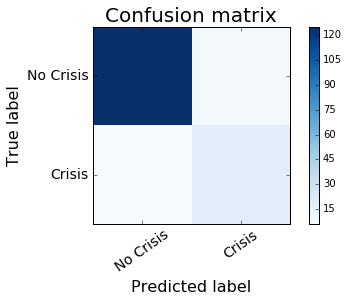

In [260]:
cm = confusion_matrix(y_testfinal, y_pred, labels=None)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

In [236]:
def getROCcurve(X_train, X_test, y_train, y_test, model):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
#     print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='AUC: %0.3f' % auc)

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('False Postive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Random Forest ROC Curve for Climate-Triggered Refugee Disasters', fontsize=16)
    plt.legend(loc='best', fontsize=14)

In [181]:
def getROCcurve2(X_train, X_test, y_train, y_test, models):
    for m in models:
        model.fit(X_train, y_train)
        y_scores = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_scores)

        auc = roc_auc_score(y_test, y_scores)
    #     print('AUC: {}'.format(auc))

        fig,ax = plt.subplots()
        ax.plot(fpr, tpr, label='AUC: %0.3f' % auc)

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('False Postive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Random Forest ROC Curve for Climate-Triggered Refugee Disasters', fontsize=16)
    plt.legend(loc='best', fontsize=14)

In [257]:
test2013 = df.xs(2013, level='year', axis=0)

In [261]:
train2013 = pd.concat([training_sets[5], df.xs(2012, level='year', axis=0)])

In [262]:
X_train, X_test, y_train, y_test = train2013[x_cols], test2013[x_cols], train2013['zscores'], test2013['zscores']

In [229]:
train2013

,forestarea,precipitation,extreme,arable_land,freshwater,zscores,binary
countrycode,,,,,,,
ARG,-0.898538,-0.695601,-0.525322,-0.241989,-0.213438,-0.278010269,1
AUS,-0.645713,-0.770911,0.936603,-0.713821,0.254668,-0.279337781,1
BRA,1.342680,0.850253,-0.365286,-0.561329,0.419393,-0.27919335,1
CHN,-0.454525,-0.624253,3.425950,-0.325690,-0.361786,-0.272709544,1
FRA,-0.072101,-0.330938,-0.607290,1.258858,-0.333392,-0.279344809,1
DEU,0.085726,-0.551585,-0.593530,1.297679,-0.385707,-0.279338859,1
IND,-0.355418,-0.045549,1.601094,2.696007,-0.387855,-0.278465706,1
IDN,1.035350,2.093542,-0.528672,-0.304733,-0.173677,-0.269939515,1
ITA,-0.036402,-0.377181,-0.606587,0.650412,-0.333428,-0.279312434,1


In [231]:
y2013 = df.xs(2013, level='year', axis=0)

In [235]:
df.xs(2013, level='year')

,forestarea,precipitation,extreme,arable_land,freshwater,zscores,binary
countrycode,,,,,,,
ARG,-0.934302,-0.695601,-0.525322,-0.113965,-0.226092,-0.26509832,1
AUS,-0.661150,-0.770911,0.936603,-0.727903,0.187319,-0.265693695,1
BRA,1.290839,0.850253,-0.365286,-0.505350,0.372068,-0.265421506,1
CHN,-0.403036,-0.624253,3.425950,-0.348644,-0.363567,-0.254964769,1
FRA,-0.006849,-0.330938,-0.607290,1.254601,-0.335988,-0.26567294,1
DEU,0.089866,-0.551585,-0.593530,1.301025,-0.384957,-0.2656215,1
IND,-0.321926,-0.045549,1.601094,2.655584,-0.390599,-0.265135293,1
IDN,0.915590,2.093542,-0.528672,-0.224897,-0.192503,-0.261355837,1
ITA,0.021550,-0.377181,-0.606587,0.515442,-0.336099,-0.265702354,1
